# Preparing Datasets for DNN-based Speech Recognition

## Introduction

This notebook demonstrates how to prepare a **PyTorch-compatible** Wall Street Journal (WSJ) dataset for speech recognition. 

The following topics will be covered in order:

1. [Creating Labels from Transcripts with Transcript Maps](#1)
2. [Creating a Labeled Dataset with WSJ0 and Transcript Maps](#2)
3. [Adding Transforms to the Labeled Dataset](#3)
4. [Visualize Features](#4)
5. [Summary](#5)

Modules used in this notebook are:

- `audlib.dat.wsj.WSJ0` -- a PyTorch-compatible dataset class for WSJ0
- `audlib.asr.util.PhonemeMap` -- a transcript-to-phoneme map
- `audlib.asr.util.CharacterMap` -- a transcript-to-character map
- `audlib.audlib.sig.fbanks.MelFreq` -- the Mel-frequency filterbank with methods such as `melspec` and `mfcc`
- `audlib.sig.stproc` -- a module for short-time signal analysis
- `audlib.sig.window` -- a module of window functions

---
<a name="1"></a>

## Creating Labels from Transcripts with Transcript Maps

Mapping transcripts (a sequence of words) to labels (a sequence of integers) requires a set of definitions:

1. The atomic unit of a transcript, along with all possible vocabularies. Available options are:
    - phoneme (`PhonemeMap`)
    - character (`CharacterMap`)

2. The transformation that converts a transcript to a sequence of atomic units chosen in step 1.
    - For characters, this step does nothing, except probably formatting text to a standard form (e.g. CAPITALIZED).
    - For phonemes, this step **requires a dictionary** that maps a word to a valid phoneme.

In [1]:
import os
import audlib
from audlib.asr.util import PhonemeMap, CharacterMap
from pprint import pprint
_moddir = os.path.dirname(audlib.__file__)
dictpath = os.path.join(_moddir, '../audlib/misc/cmudict-0.7b')
phonepath = os.path.join(_moddir, '../audlib/misc/wsj.phone')
print("Creating a phoneme map.")
pmap = PhonemeMap(dictpath)
print("Dictionary contains [{}] valid words.".format(len(pmap.dict)))
print("[{}] valid phonemes. Printing first 5 entries:".format(len(pmap.vocabdict)))
pprint(["{}: {}".format(k,v) for (k,v) in pmap.vocabdict.items()][:5])

# Test random sentences
sentences = ["This is a sentence to be processed by SPHINX",
            "This is a sentence to be processed by CMUSPHINX"]
for ss in sentences:
    print("Testing phoneme map with [{}]".format(ss))
    if not pmap.transcribable(ss):
        pprint("OOV in [{}]: [{}]".format(ss, pmap.trans2oov(ss)))
    else:
        print("phoneme sequence ---> [{}]".format(pmap.trans2vocab(ss)))
        print("label sequence ---> [{}]".format(pmap.trans2label(ss)))


Creating a phoneme map.
Dictionary contains [134373] valid words.
[69] valid phonemes. Printing first 5 entries:
['AA0: 0', 'AA1: 1', 'AA2: 2', 'AE0: 3', 'AE1: 4']
Testing phoneme map with [This is a sentence to be processed by SPHINX]
phoneme sequence ---> [['DH', 'IH1', 'S', 'IH1', 'Z', 'AH0', 'S', 'EH1', 'N', 'T', 'AH0', 'N', 'S', 'T', 'UW1', 'B', 'IY1', 'P', 'R', 'AA1', 'S', 'EH0', 'S', 'T', 'B', 'AY1', 'S', 'F', 'IH1', 'NG', 'K', 'S']]
label sequence ---> [[21, 35, 54, 35, 67, 6, 54, 23, 44, 56, 6, 44, 54, 56, 62, 18, 38, 52, 53, 1, 54, 22, 54, 56, 18, 16, 54, 31, 35, 45, 41, 54]]
Testing phoneme map with [This is a sentence to be processed by CMUSPHINX]
"OOV in [This is a sentence to be processed by CMUSPHINX]: [{'CMUSPHINX': 1}]"


In [2]:
from audlib.asr.util import CharacterMap

print("Creating a character map")
cmap = CharacterMap("ABCDEFGHIJKLMNOPQRSTUVWXYZ ")
print("Dictionary contains [{}] valid characters. Printing first 5 entries:".format(len(cmap.vocabdict)))
print(["{}: {}".format(k,v) for (k,v) in cmap.vocabdict.items()][:5])
# Test random sentences
sentences = ["This is a sentence to be processed by SPHINX",
            "This is a sentence to be processed by CMUSPHINX"]
for ss in sentences:
    print("Testing phoneme map with [{}]".format(ss))
    if not cmap.transcribable(ss):
        pprint("OOV in [{}]: [{}]".format(ss, cmap.trans2oov(ss)))
    else:
        print("character sequence ---> [{}]".format(cmap.trans2vocab(ss)))
        print("label sequence ---> [{}]".format(cmap.trans2label(ss)))

Creating a character map
Dictionary contains [27] valid characters. Printing first 5 entries:
[' : 0', 'A: 1', 'B: 2', 'C: 3', 'D: 4']
Testing phoneme map with [This is a sentence to be processed by SPHINX]
character sequence ---> [['T', 'H', 'I', 'S', ' ', 'I', 'S', ' ', 'A', ' ', 'S', 'E', 'N', 'T', 'E', 'N', 'C', 'E', ' ', 'T', 'O', ' ', 'B', 'E', ' ', 'P', 'R', 'O', 'C', 'E', 'S', 'S', 'E', 'D', ' ', 'B', 'Y', ' ', 'S', 'P', 'H', 'I', 'N', 'X']]
label sequence ---> [[20, 8, 9, 19, 0, 9, 19, 0, 1, 0, 19, 5, 14, 20, 5, 14, 3, 5, 0, 20, 15, 0, 2, 5, 0, 16, 18, 15, 3, 5, 19, 19, 5, 4, 0, 2, 25, 0, 19, 16, 8, 9, 14, 24]]
Testing phoneme map with [This is a sentence to be processed by CMUSPHINX]
character sequence ---> [['T', 'H', 'I', 'S', ' ', 'I', 'S', ' ', 'A', ' ', 'S', 'E', 'N', 'T', 'E', 'N', 'C', 'E', ' ', 'T', 'O', ' ', 'B', 'E', ' ', 'P', 'R', 'O', 'C', 'E', 'S', 'S', 'E', 'D', ' ', 'B', 'Y', ' ', 'C', 'M', 'U', 'S', 'P', 'H', 'I', 'N', 'X']]
label sequence ---> [[20, 8, 9, 19,

---
<a name="2"></a>

## Creating a Labeled Dataset with WSJ0 and Transcript Maps

Once we have defined a valid map in the previous section, we can build a labeled dataset in `audlib.dat`. Available options for speech recognition are:

- The Wall Street Journal 1992 (`audlib.dat.wsj.WSJ0`)
- The Wall Street Journal 1993 (`audlib.dat.wsj.WSJ1`)

In [3]:
from audlib.data.wsj import WSJ0, ASRWSJ0
wsj0root = '/home/xyy/data/wsj0'  # change to your wsj0 path
replmap = {"\\": "",
           "[LOUD_BREATH]": "",
           "[LIP_SMACK]": "",
           "[TONGUE_CLICK]": "",
           ".": " ",
           "~": "",
           "[EXHALATION]": ""
          }  # some replacement map for cleaning up transcripts
pmap_cleaned = PhonemeMap(dictpath, replacemap=replmap)
wsj0 = WSJ0(wsj0root, filt=lambda fn: fn.endswith('.wv1'))
dataset = ASRWSJ0(wsj0, pmap_cleaned)
print("Writing OOV to file to [oov.txt]")
with open('oov.txt', 'w') as fp:
    fp.write('\n'.join(["{}: {}".format(k,v) for (k,v) in sorted(
        dataset.oovs.items(), key=lambda x: x[1], reverse=True)])+'\n')

Writing OOV to file to [oov.txt]


---
<a name="3"></a>

## Adding Transforms to the Labeled Dataset

The default `WSJ0` (among any other dataset) produces a `sample` *dictionary* at each indexing with the following fields:

- `sr`: sampling rate
- `data`: sampled audio waveform
- `label`: an array of integers as ground-truth label sequence
- `trans`: raw transcript for inspection

By adding a `tranform` argument to `WSJ0`, we can specify the final form of `data` or `label` before they get fed into a neural network.

In [4]:
# Prepare MFCCs as the final feature vector
import numpy as np

from audlib.sig.fbanks import MelFreq
from audlib.sig.transform import stpowspec
from audlib.sig.window import hamming
from audlib.data.datatype import GenericAudio
from scipy.signal import lfilter
from scipy.fftpack import idct
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)  # scipy's throwing weird warnings

# SPHINX's reference options
"""
-alpha 0.97
-dither yes
-doublebw no
-nfilt 40
-ncep 13
-lowerf 133.33334
-upperf 6855.4976
-nfft 512
-wlen 0.0256
"""

# For STFT
sr = 16000  # sampling rate
fr = 100  # frame rate
nfft = 512  # number of DFT points
wlen = .0256  # window length in seconds
hopsize = int(sr/fr)
wind = hamming(int(wlen*sr))

# For Mel filterbank and DCT
nmel = 40
melbank = MelFreq(sr, nfft, nmel, unity=True)

def transform(sample):
    sig = sample.signal
    label = sample.label
    
    # pre-emphasis
    sig = lfilter([1, -0.97], [1], sig)
    
    # dithering
    
    # extract MFCCs
    powerspec = stpowspec(sig, sr, wind, hopsize, nfft)
    melspec = np.log(melbank.melspec(powerspec))
    mfcc = melbank.mfcc(powerspec)
    
    # cepstral mean normalization
    mfcc -= mfcc.mean(axis=0)
    
    # inverse transform to mel spectral domain
    melspec_cmn = idct(mfcc, norm='ortho')
    
    # This is for demonstration purpose only. In actual batching for DNN, only 'data' and 'label'
    # will be passed along.
    out = GenericAudio(signal=melspec_cmn / np.std(melspec_cmn, axis=-1)[:, np.newaxis])
    out.label = np.array(label)
    out.melspec = melspec
    out.melspec_cmn = melspec_cmn  # pass on different features for comparison

    return out

# Finally, add the pre-defined transform to the dataset
wsj0 = WSJ0(wsj0root, filt=lambda fn: fn.endswith('.wv1'), transform=transform)
dataset = ASRWSJ0(wsj0, pmap_cleaned)
nframe_tot = 0
nlabel_tot = 0
for ii, sample in enumerate(dataset):
    if ii == 32:  # simulate a batch
        break
    if (ii+1) % 100 == 0:
        print("Processing [{}/{}] file.".format(ii+1,len(dataset)))
    data = sample.signal
    label = sample.label
    nframe_tot += len(data)
    nlabel_tot += len(label)

print("""\n******Summary of WSJ0 Dataset [32] examples******
There are total [{}] frames of MFCCs.
There are total [{}] phoneme labels.
""".format(nframe_tot, nlabel_tot))


******Summary of WSJ0 Dataset [32] examples******
There are total [20099] frames of MFCCs.
There are total [2155] phoneme labels.



---
<a name="4"></a>

## Visualize Features

Three different types of features are plotted below for visual comparison:

- 40-dimensional Mel spectrogram
- 40-dimensional Mel spectrogram with cepstral mean normalization (CMN) per utterance
- 40-dimensional Mel spectrogram with cepstral mean variance normalization (CMVN) per utterance

Text(0.5, 0, 'Log Mel Spectrogram with CMVN')

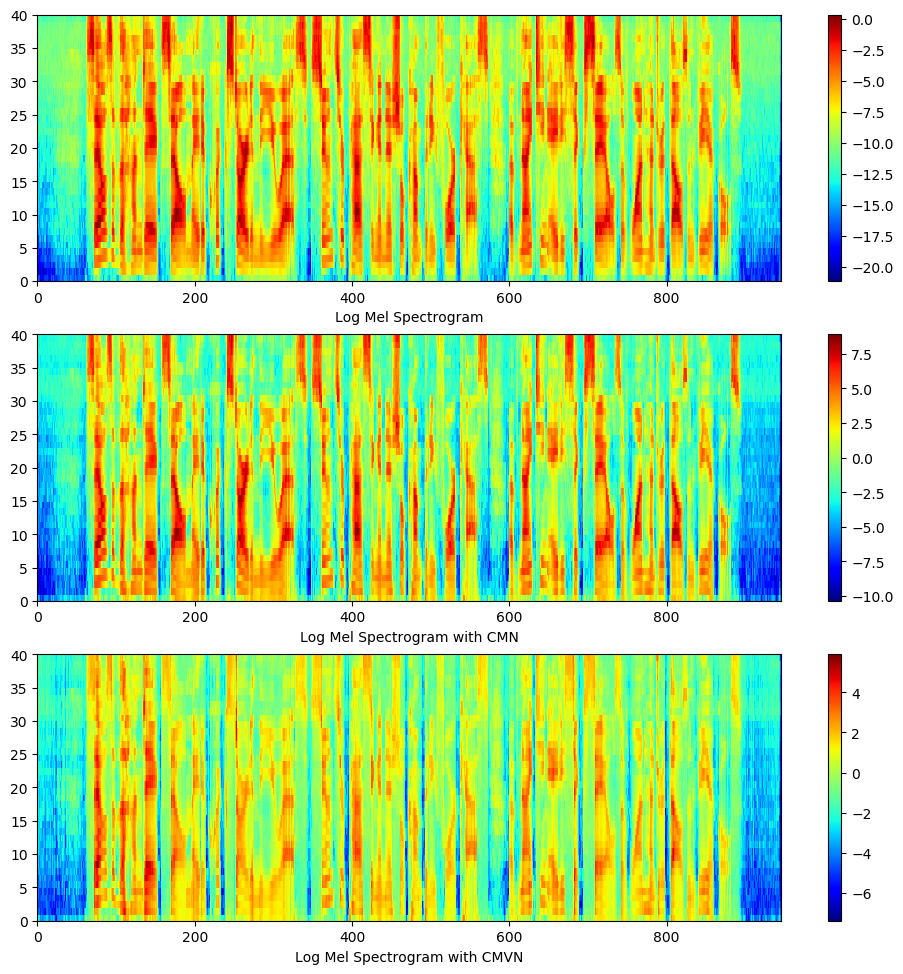

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12), dpi=100)
ax1 = fig.add_subplot(311)
mesh = ax1.pcolormesh(dataset[0].melspec.T, cmap='jet')
plt.colorbar(mesh, ax=ax1)
ax1.set_xlabel("Log Mel Spectrogram")
ax2 = fig.add_subplot(312)
mesh = ax2.pcolormesh(dataset[0].melspec_cmn.T, cmap='jet')
plt.colorbar(mesh, ax=ax2)
ax2.set_xlabel("Log Mel Spectrogram with CMN")
ax3 = fig.add_subplot(313)
mesh = ax3.pcolormesh(dataset[0].signal.T, cmap='jet')
plt.colorbar(mesh, ax=ax3)
ax3.set_xlabel("Log Mel Spectrogram with CMVN")

---
<a name="5"></a>

## Summary 

We have successfully created a WSJ0 dataset training partition by the following:

1. Created a transcript-to-phoneme map using `audlib.asr.util.PhonemeMap`.
    - The transcript-to-character map is also available in `audlib.asr.util.CharacterMap`.

2. Created a dataset with a phoneme map using `audlib.dat.wsj.WSJ0`.
    - WSJ0 (as well as WSJ1, and other available datasets) follows the `torch.utils.data.Dataset` convention in PyTorch.

3. Created a `transform` function for the dataset created in step 2.
    - The default behavior of any dataset takes in an *optional* `transform` function for transforming the `sample` dictionary at each index to something viable for the task at hand. If not specified, raw audio waveforms and labels are provided.
    - The example `transform` function computes the 40-dimensional Mel spectrogram with different normalizations.
        - All hyper-parameters are consistent with the default setup in SPHINX
        - `audlib.sig.window.hamming` and `audlib.sig.stproc.stana` are used for short-time analysis (framing)
        - `audlib.sig.fbanks.MelFreq` is used to build a Mel filterbank
        - `mfcc` and `melspec` in `audlib.sig.fbanks.MelFreq` are used to compute the 40-dimensional Mel spectrograms

4. Visualized Mel spectrograms with three different normalization settings.
    - CMN and CMVN are widely used in speech recognition.
    - Although CMVN is visually less expressive than CMN or the original, it doesn't necessarily mean it'll be worse in terms of recognition accuracy.